# Transfer Learning : Learning under covariate shift


In this notebook, I will describe and implement learning under "covariate shift", which is a form of transfer learning problem. 

* Section 1 introduces transfer learning in general.  
* Section 2 defines the setting of covariate shift, and gives toy data. 
* Section 3 implements learning under covariate shift with the assumption that input probability densities are known. 
* Section 4 implements learning under covariate shift where the assumption in the previous section is lifted. 
* Section 5 shows reference.

Although the formulation and the algorithm is based on a Japanese textbook [1], I will cite English papers when needed.

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rc("savefig",dpi=100)

## 1 Transfer learning in general

### 1.1 What is transfer learning?

In conventional machine learning setting, it is assumed that training data and test data are generated from the same probability distribution. 
However, the assumption does not necessarily hold in real applications, or, sometimes, we want to utilize past data in a way that the assumption is violated. 

Let us consider an example called "sentiment classification [2]", in which we try to classify whether a review on an item is positive or negative.  

1. Suppose that the web site owner is trying to build an algorithm that classify reviews on movies. 
2. Although she does not have labeled data of reviews on movies, suppose she has labeled data of reviews on books. 
3. The straightforward approach of simply training a classifier on book review data and applying it to movie review may not work properly. This is because, simply put, book reviews and movie reviews are "different"; for example, vocabulary used in two categories are different. 
4. On the other hand, labelling movie review data by herself is a cumbersome task. Because movie and book reviews have some properties in common, and she has labeled book review data, she wonders whether it is possible to utilize book review data to train a classifier on movie reviews.

Transfer learning [2,3] is a category of machine learning addressing such problems.
More generally, transfer learning tries to extract insight or knowledge from a class of data, and transfer them to a different class of data to build a better predictor on the new data.

Formal definition will be given in Section 1.3. 


### 1.2 notation

Before delving in to the formulation, we will define some symbols first. 

As was stated, transfer learning tries to extract insight or knowledge from a class of data, and transfer them to a different class of data to build a better predictor on the new data.
We call 
* the original domain or task, from which knowledge are transferred, "source", which will be dentoed by $s$, and 
* the new data or task, to which knowledge are transferred, "target", which will be denoted by $t$.

For simplicity, here we only consider supervised learning, where our task is to predict an output $y$ given a input $x$.

Let us define symbols as follows ($\alpha \in \{ s,t \}$):
* $\mathcal{X}_{\alpha}$ : the set representing the range input variables. 
* $\mathcal{Y}_{\alpha}$ : the set representing the range of output variables.
* $P_{\alpha}$ : a probability over $\mathcal{X}$. 
* $P_{\alpha}(\cdot|x)$ : a probability over $\mathcal{Y}$ given $x \in \mathcal{X}$. 

We call 
* $\mathcal{D}_{\alpha} = \left( \mathcal{X}_{\alpha}, P_{\alpha}(\cdot) \right)$ a domain, which concerns input part, and 
* $\mathcal{T}_{\alpha} = \left( \mathcal{Y}_{\alpha}, P_{\alpha}(\cdot | \cdot) \right)$ a task, which concerns output part.


### 1.3 Definition of transfer learning

With the notation, a (rough) definition of transfer learning can be given [2]: 

Transfer learning is a subfield of machine learning, which 
* considers learning problems under situations where $\mathcal{D}_s \neq \mathcal{D}_t$ or $\mathcal{T}_s \neq \mathcal{T}_t$, and 
* tries to improve performance of predictor ontarget domain / task $\left( \mathcal{D}_t, \mathcal{T}_t \right)$, by transferring knowledge acquire from source domain / task $\left( \mathcal{D}_s, \mathcal{T}_s \right)$. 

There can be many ways $\mathcal{D}_s \neq \mathcal{D}_t$ or $\mathcal{T}_s \neq \mathcal{T}_t$ holds, and there are many approaches to these settings. 

In this notebook, we only consider a class of situation called "covariate shift", whose definition will be given in the next section. 

For more detail on transfer learning in general, readers are referred to 
* [2]Pan, Yang (2010) "A Survey on Transfer Learning" IEEE Transactions on Knowledge and Data Engineering
* [3]Sebastian Ruder (2017) "Transfer Learning - Machine Learning's Next Frontier" http://ruder.io/transfer-learning/

The former paper is a little bit old, and does not deal with new topics such as deep neural netowrks. 
The latter deals with such topics. 

## 2 Covariate shift

### 2.1 Definition

Covariate shift, or domain adaptation, is a setting of transfer learning, where 
$$
\begin{align}
    \mathcal{T}_s = \mathcal{T}_t, \ \ \mathcal{X}_s = \mathcal{X}_t, \ \ 
    P_s(\cdot) \neq P_t(\cdot)
\end{align}
$$
holds[4]. 

In this notebook, we consider a simple example of machine learning under covariate shift.


### 2.2 Notation

Let us define the symbols as follows: 
* $N \in \mathbb{N}$ : the number of source training data
* $X = (x_0, x_1, \dots, x_{N-1})$ : soruce training input data
* $Y = (y_0, y_1, \dots, y_{N-1})$ : soruce training label
* $N' \in \mathbb{N}$ : the number of target data
* $X' = (x'_0, x'_1, \dots, x'_{N'-1})$ : target input data

* $p_{\alpha}$ : the probability density representing the input probability distribution $P_{\alpha}$
* $p(y|x)$ : the conditional probability of output $y$ given input $x$. 

We assume that we have a model of conditional probability $p(y|x, \theta)$, which is parametrized by $\theta \in \Theta$. It should be noted that $p(y|x, \theta)$ is usually different from the true conditional probability $p(y|x)$.

### 2.3 Toy data

In this notebook, we use the following toy data :

* $\mathcal{X} = \mathbb{R}^2$
* $\mathcal{Y} = \left\{ 0, 1 \right\}$
* $p_{\alpha}\left(x=(x_1, x_2)\right) = \mathcal{N}\left(x_1 \middle| \mu_\alpha, \sigma^2 \right) \ U\left(x_2 \middle| m, M \right)$, where
    * $\mathcal{N}\left( \cdot \middle| \mu_\alpha, \sigma^2 \right)$ stands for a one-dimensional Gaussian distribution with mean $\mu_\alpha \in \mathbb{R}$ and variance $\sigma^2 >0$, and 
    * $U\left(\cdot \middle| m, M \right)$ stands for one-dimensional uniform distribution with minimum m and maximum M

We use the following function to generate data:

In [2]:
# for data generation 

def gen_data_and_label(num, mu, sigma, ymin, ymax ):
    data = np.zeros( (num, 2) )
    data[:,0] = sigma*np.random.randn( num ) + mu
    data[:,1] = (ymax - ymin)*np.random.rand( num ) + ymin
    
    label = (data[:,1] > np.sin(np.pi*data[:,0]) ).astype("int")
    return data, label

Fow later convenience, here we define a function which returns a quantity called "importance", i.e., the ratio of target probability density to the source pobability density. 

In [3]:
def importance(X, params):
    if len(np.shape(X)) > 1 :
        x1 = X[:,0]
    else:
        x1 = X
    d_source = norm.pdf(x1, loc=params["mu_source"], scale = params["sigma_source"])
    d_target = norm.pdf(x1, loc=params["mu_target"], scale = params["sigma_target"])
    return d_target/d_source

The following block takes care of data plotting.

In [4]:
# for data plotting

def plot_data(ax, data1, data2, xlims, ylims, names):
    ax.plot(data1[:,0], data1[:,1], 'o', label = names[0])
    ax.plot(data2[:,0], data2[:,1], 'o', label = names[1])
    ax.legend()
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])

def plot_density_and_weight(ax, xlims, params, weight_function = None):
    xx = np.linspace(xlims[0], xlims[1], 101)
    ax.plot(xx, norm.pdf(xx, loc=params["mu_source"], scale = params["sigma_source"]) , label = "source" )
    ax.plot(xx, norm.pdf(xx, loc=params["mu_target"], scale = params["sigma_target"]) , label = "target" )
    ax.legend()
    if not( weight_function is None):
        ax2 = ax.twinx()
        ax2.plot(xx, weight_function(xx, params),  "--", label = "weight")
        ax2.legend()
    
def plot_data_and_label(ax, data, label, xlims, ylims, title = None):
    pos = np.where(label == 1)
    neg = np.where(label == 0)
    ax.plot(data[pos][:,0], data[pos][:,1], 'o' )
    ax.plot(data[neg][:,0], data[neg][:,1], 'x' )
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    if not( title is None):
        ax.set_title(title)
    xx = np.linspace(xlims[0],xlims[1],101)
    plt.plot(xx, np.sin(np.pi*xx))
    
def plot_fig_datacomparison(data1, data2, label1, label2, xlims, ylims, weight_function, params):
    fig = plt.figure(figsize=(12,10))
    
    ax = fig.add_subplot(2, 2, 1)
    plot_data(ax, data1, data2, xlims, ylims, ["source", "target"])
    
    ax = fig.add_subplot(2, 2, 2)
    plot_density_and_weight(ax, xlims, params = params, weight_function = weight_function)
    
    ax = fig.add_subplot(2, 2, 3)
    plot_data_and_label(ax, data1, label1, xlims, ylims, "source")
    
    ax = fig.add_subplot(2, 2, 4)
    plot_data_and_label(ax, data2, label2, xlims, ylims, "target")
    
    return fig

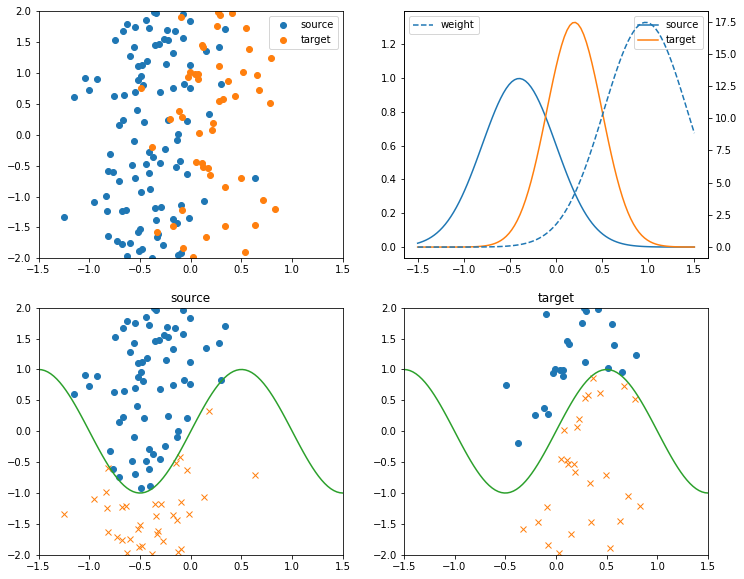

In [38]:
num_source = 100
num_target = 50
ymin = -2
ymax = 2

params = {"mu_source" : -0.4, \
          "mu_target" : 0.2, \
          "sigma_source" : 0.4, \
          "sigma_target": 0.3}

data_source, label_source = gen_data_and_label(num_source, params["mu_source"], params["sigma_source"], ymin, ymax)
data_target, label_target = gen_data_and_label(num_target, params["mu_target"], params["sigma_target"], ymin, ymax)

xlims = np.array([-1.5, 1.5])
ylims = np.array([-2, 2])

fig = plot_fig_datacomparison(data_source, data_target, label_source, label_target, xlims, ylims, importance, params)
plt.show()

It should be noted that, for the target data, only the input data are available in training phase, because avoiding the need of labeled data in target domain, which is highly costly, is our motivation to utilize existing source data.

## 3 Learning under covariate shift 1: known probability densities

In this section, we first assume that the input probability densities $p_{\alpha}$ are known. 
More realistic situation where we do not know $p_{\alpha}$ will be treated in the next section. 

### 3.1 Theory

Under covariate shift, it is shown that, the following weighted maximum likelihood estimation wil work [4]

$$
\begin{align}
    L_w\left(\theta \middle|  X, Y \right) &:= - \frac{1}{N} \sum_{n=0}^{N-1}w(x_n) \log p\left(y_n \middle| x_n, \theta \right) \\
    w(x) &= \frac{p_t(x)}{p_s(x)}
\end{align}
$$

Here, "work" means that the estimated value $\hat{\theta}$ given by minimizing the above likelihood function will converge ( in the limit of $N \rightarrow \infty$) to $\theta^{\ast}$, which minimizes the KL divergence between the true distribution and the parametrized model (For more precise and rigorous statement please see [4]. )

The idea behind this procedure is the following relation : 
$$
\begin{align}
    L_w\left(\theta \middle|  X, Y \right) &:= - \frac{1}{N} \sum_{n=0}^{N-1}w(x_n) \log p\left(y_n \middle| x_n, \theta \right) \\
    & \simeq \sum_{y=0,1} \int p_s(x) p(y|x) w(x) \log p\left(y \middle| x, \theta \right) dx　\\
    & = \sum_{y=0,1} \int p_t(x) p(y|x) \log p\left(y \middle| x, \theta \right) dx, 
\end{align}
$$
which is a loss function with respect to target distribution.


In [6]:
class LogisticRegression_covshift(LogisticRegression):
    def fit_covshift(self, X, y, weight_function, params = None):
        sample_weight = weight_function(X, params)
        super().fit(X, y, sample_weight)

### 3.2 Experiment with the toy data

Because we have already defined our importance weight function, we can perform the importance weighted learning as follows:

In [7]:
# for visualizing the result of learning

def plot_decision_boundary(ax, xlims, ylims, clf):
    a = clf.coef_[0,0]
    b = clf.coef_[0,1]
    c = clf.intercept_[0]
    ax.plot(xlims, -a/b*xlims- c/b)
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])

def plot_fig_result(data_source, data_target, label_source, label_target, xlims, ylims, clf, fig_title):
    
    fig = plt.figure(figsize=(12, 5))
    
    ax = fig.add_subplot(1, 2, 1)
    plot_data_and_label(ax, data_source, label_source, xlims, ylims, title="source training data")
    plot_decision_boundary(ax, xlims, ylims, clf)
    
    ax = fig.add_subplot(1, 2, 2)
    plot_data_and_label(ax, data_target, label_target, xlims, ylims, title="target data")
    plot_decision_boundary(ax, xlims, ylims, clf)
    
    fig.suptitle(fig_title)

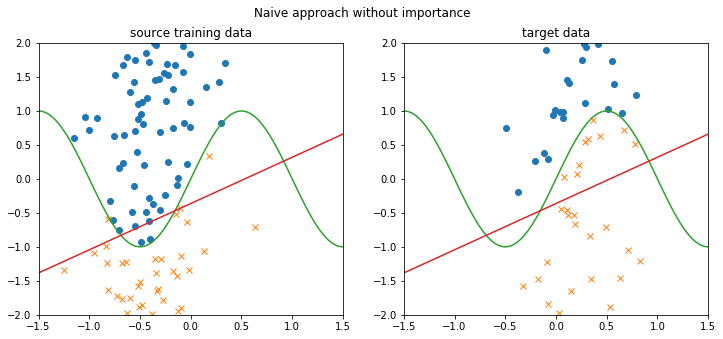

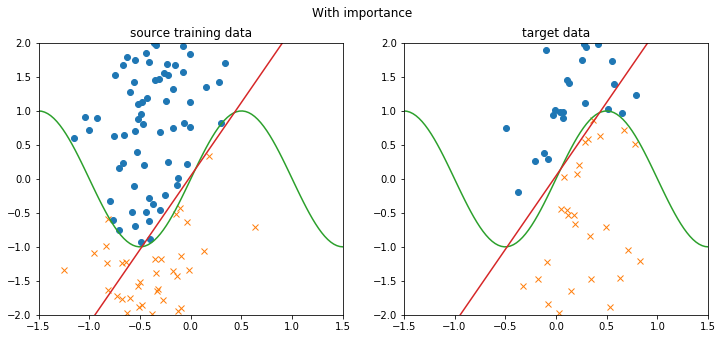

In [39]:
clf_naive = LogisticRegression(penalty='l2', C = 1e50)
clf_naive.fit(data_source, label_source)
plot_fig_result(data_source, data_target, label_source, label_target, xlims, ylims, clf_naive, "Naive approach without importance")

clf_weight_known = LogisticRegression_covshift(penalty='l2', C = 1e50)
clf_weight_known.fit_covshift(data_source, label_source, importance, params)
plot_fig_result(data_source, data_target, label_source, label_target, xlims, ylims, clf_weight_known, "With importance")

plt.show()

We can see that the result obtained by taking into account of covariate shift fits much better with the target data.

### 3.3 Note

Shimodaira [4] pointed out that, for moderate sample size, it is not necessarily the best choice to set the imoprtance as the weight function. This is because the choice may induce large variance due to sampling error. 

We can antiticipate this problem from the out toy example: if the two distributions are far away from each other, then the values of importance weight function are almost zero except for the right-most part of the figure, which means that the learning is significantly affected by small numbers of samples. 

The author proposes to try other weight functions, and gives an information criteria for selecting an appropriate weight function. For the detail, please see [4].

## 4 Learning under covairate shift 2 : unknown densities

Here, we consider more realistic situation, where we do not know the marginal probability densities $p_{\alpha}(\cdot)$ of source and target domain. 

To apply the method shown in the previous section, we have to estimate the densities or their ratio from data. 
Note that although we assume labeled target data are not available in the training phase, we can nevertheless obtain the target input data, which we will use for the estimation. 


### 4.1 Estimating the densities 

A naive approach is to estimate the densties $p_{\alpha}(\cdot)$ from input source / target data, and then taking their ratio to obtain the importance weight. 

However, density estimation is known to be a difficult task, especially in high dimensions (See introductions of [5,6] and references therein.).

Note : I should have tried this direct approach on the toy data...

### 4.2 Directly estimating the density ratio

An alternative approach is to estimate the density ratio directly without estimating each density [5,6]. 

We use the following model 

$$
\begin{align}
    w_\theta(x) = \sum_{j=0}^{b-1} \theta_j \phi_j(x) = \theta^T \phi(x), 
\end{align}
$$

where $b \in \mathbb{N}$ is the number of basis function, 
to express the importance weight. 
We assume $\phi_j(x) \geq 0 $ for all $x \in \mathcal{X}$.

Alghouth there are several choices of loss functions, 
we use a simple square loss function employed in [5]

$$
\begin{align}
    J(\theta) &= \frac{1}{2} \int \left[ w_{\theta}(x) - \frac{p_t(x)}{p_s(x)} \right]^2 p_s(x) dx \\
    &= \frac{1}{2} \int w_{\theta}^{2}(x) p_s(x) dx - \int w_{\theta}(x) p_t(x) dx + \textrm{Const} \\
    &= \frac{1}{2} \sum_{i,j = 0}^{b-1} \theta_i \left[ \int \phi_i(x) \phi_j(x) p_s(x) dx\right] \theta_j
        - \sum_{i=0}^{b-1} \theta_i \left[ \int \phi_i(x) p_t(x) dx \right]  + \textrm{Const} \\
    &= \frac{1}{2} \theta^T H \theta - h^T \theta + \textrm{Const}, 
\end{align}
$$

where 

$$
\begin{align}
    H_{i,j} &:= \int \phi_i(x) \phi_j(x) p_s(x) dx \\
    h_{i} &:= \int \phi_i(x) p_t(x) dx
\end{align}
$$

Because we do not know the true distribution $p_{\alpha}(\cdot)$, we replace the expectation value by summation, and obtain the following loss function: 

$$
\begin{align}
    \tilde{J}(\theta) &:=  \frac{1}{2} \theta^T \tilde{H} \theta - \tilde{h}^T \theta \\
    \tilde{H}_{i,j} &:= \frac{1}{N} \sum_{l=0}^{N-1} \phi_i(x_l) \phi_j(x_l) \\
    \tilde{h}_{i} &:= \frac{1}{N'} \sum_{l=0}^{N'-1} \phi_i(x'_l)
\end{align}
$$

By adding a $l^1$ regularization term whose coefficient is given by $\lambda >0$, we have to the following optimization problem

$$
\begin{align}
    \textrm{minimize } \tilde{J}(\theta) &=  \frac{1}{2} \theta^T \tilde{H} \theta - \tilde{h}^T \theta + \lambda \| \theta \|_1 \\ 
    & s.t. \theta_j \geq 0 \ (\forall j \in \{ 0,1, \dots, b-1\} )
\end{align}
$$

The hyper-parameters $s$ and $\lambda$ will be determined with cross-validatoin (See section 4.4).

### 4.3 Gaussian Kernel basis function

In this notebook, as basis functions $\phi$, we use Gaussian kernel functions centered at target data points, following [5]. 
For the reason of using only target data points, please see Sectoin 2.5 of [5]

$$
\begin{align}
    \phi_i(x) \rightarrow K_h(x, x_i)
    K_s(a,b) := \exp\left[ -\frac{ (a -b)^2 }{2s^2} \right]
\end{align}
$$
where $s > 0$ is a hyper parameter defining the width of the gaussian. 
With this notation, we have

$$
\begin{align}
    w_{\theta}(x) &= \sum_{i=0}^{N'-1} \theta_i K_s(x, x'_i) \\
    \tilde{H}_{i,j} &=  \frac{1}{N} \sum_{l=0}^{N-1} K_s(x_l, x'_i) K_s(x_l, x'_j) \\
    \tilde{h}_i &= \frac{1}{N'} \sum_{l=0}^{N'-1} K_s(x'_l, x'_i)
\end{align}
$$

With these definitions, we give an estimator for the probability density ratio.

In [36]:
### estimator that estimates probability density ratio

class LSDensityRatioEst:
    def __init__(self, hparams = {'s':0.1, 'lam':0.01}):
        self.s = hparams['s']  
        self.lam = hparams['lam']
        self.theta = None
        self.data_center = None
    
    def genK(self, A, B):
        '''
        For generating the gaussian kernel matrix
        inputs
         A : rank-2 array, with shape (Na, d), where a_i \in \mathbb{R}^{d} (i = 1,2, \dots, Na) OR 1D array with length Na (which corresponds to d=1)
         B : rank-2 array, with shape (Nb, d), where b_i \in \mathbb{R}^{d} (i = 1,2, \dots, Nb) OR 1D array with length Nb (which corresponds to d=1)
         h : a positive number
         output
         K : Na \times Nb matrix, with K_{i,j} = k(a_i,b_j) = \\exp\left( -\frac{\theta_1}{2} \| a_i- b_j \|^2 \right)
        '''
        # make sure that A and B are matrices
        if len(np.shape(A)) == 1:
            A = np.reshape(A, (len(A),1))
        if len(np.shape(B)) == 1:
            B = np.reshape(B, (len(B),1))

        tmp = np.reshape(np.sum(A**2, axis=1),(len(A),1)) + np.sum(B**2, axis=1)  -2*(A @ B.T)
        return np.exp(-tmp/(2*self.s**2)) 

    def loss_function_raw(self, theta, data_source, data_target, lam):
        Kmat_sc = self.genK(data_source, self.data_center) 
        Kmat_tc = self.genK(data_target, self.data_center) 
        H = 1.0/len(data_source)* (Kmat_sc.T) @ Kmat_sc
        h = 1.0/len(data_target)*np.sum(Kmat_tc, axis=0)
        return 0.5*(theta @ H @ theta) - h @theta + lam*np.sum(theta)
        
    def loss_function(self, theta, H, h, lam):
        return 0.5*(theta @ H @ theta) - h @theta + lam*np.sum(theta)
        
    def fit(self, data_source, data_target):
        #self.data_center = data_target
        self.data_center = np.concatenate((data_source, data_target), axis=0)
        Kmat_sc = self.genK(data_source, self.data_center) 
        Kmat_tc = self.genK(data_target, self.data_center) 
        H = 1.0/len(data_source)* (Kmat_sc.T) @ Kmat_sc
        h = 1.0/len(data_target)*np.sum(Kmat_tc, axis=0)
        
        theta0 = np.random.random(len(self.data_center))
        const = {'type':'ineq', 'fun':lambda x : x}
        result = minimize(self.loss_function, theta0, args = (H, h, self.lam), constraints = const)
        self.theta = result['x']
        
    def predict(self, X):
        Kmat = self.genK(X, self.data_center)
        return Kmat @ self.theta
    
    

### 4.4 Model selection by cross validation

In the estimation of density ratio, we have to speicfy two hyper parameters, namely the kernel width $s$ and the regularization parameter $\lambda$. 

Here we employ cross validation to determine these hyper parameters, as is described in Section 2.4.2 of [5]. 

1. First, split source data and target data into $R \in \mathbb{N}$ groups. Let us denote them by $\left(X^{(s)}_r \right)_{r = 0,1, \dots, R-1}, \left( X^{(t)}_r \right)_{r = 0,1, \dots, R-1}$.
2. For each $r \in \{ 0,1, \dots, R-1\}$, 
    1. we train the estimator using data other than the selected group (i.e., $\left(X^{(s)}_j \right)_{j \neq r}, \left( X^{(t)}_j \right)_{j \neq r}$), and
    2. evaluate the performance of the learned model using the selected group $X^{(s)}_r, X^{(t)}_r $ by calculating 
    $$
    \begin{align}
        \tilde{J}_r &:=  \frac{1}{2} \theta^T \tilde{H}_r \theta - \tilde{h}_{r}^{T} \theta \\
        \tilde{H}_{r,i,j} &:= \frac{1}{\left| X^{(s)}_r \right|} \sum_{\xi \in X^{(s)}_r} \phi_i(\xi) \phi_j(\xi) \\
        \tilde{h}_{r,i} &:= \frac{1}{\left| X^{(t)}_r \right|} \sum_{\xi \in X^{(t)}_r} \phi_i(\xi), 
    \end{align}
    $$
    where $\theta$ is the learned model parameter. 
    Here we slightly abuse the notatoin, where $X^{(s)}_r, X^{(t)}_r $ are sequences rather than sets.
    3. Note that, during the procedure, the centers of gaussian kernels are fixed as $\left( X^{(t)}_j \right)_{j \neq r}$. 
3. We use the average $\frac{1}{R} \tilde{J}_r$ as the performance criterion. 

In [10]:
# cross validation

def cvscore(R, data_source, data_target, EST, hparams):
    
    est = EST(hparams)
    
    loss_function_record = np.zeros(R)
    step_source = len(data_source)//R 
    step_target = len(data_target)//R
        
    for cnt in range(R):
        data_source_train = np.concatenate(( data_source[:cnt*step_source], data_source[(cnt+1)*step_source:]  ), axis = 0)
        data_target_train = np.concatenate(( data_target[:cnt*step_target], data_target[(cnt+1)*step_target:]  ), axis = 0)
        data_source_test = data_source[cnt*step_source : (cnt+1)*step_source]
        data_target_test = data_target[cnt*step_target : (cnt+1)*step_target]

        est.fit(data_source_train, data_target_train)
        loss_function_record[cnt] = est.loss_function_raw(est.theta, data_source_test, data_target_test, 0.0)
    
    return np.mean(loss_function_record)
        

### 4.5 Experiments with the toy data

In [40]:
ss = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] # the width of Gaussian kernels
ll = [0.01, 0.03, 0.1, 0.3, 1.0] # regularization parameter
scores = np.zeros((len(ss),len(ll)))

for (cnts,s) in enumerate(ss):
    for (cntl,l) in enumerate(ll):
        hparams = {'s':s, 'lam':l}
        scores[cnts, cntl] = cvscore(5, data_source, data_target, LSDensityRatioEst, hparams)
        print(f's : {s}, lambda : {l}')
        
ind = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
s = ss[ind[0]]
lam = ll[ind[1]]
print(f"s = {s}, lambda = {lam}")

hparams = {'s':s, 'lam':lam}
lsdr = LSDensityRatioEst(hparams)
lsdr.fit(data_source, data_target)

s : 0.1, lambda : 0.01
s : 0.1, lambda : 0.03
s : 0.1, lambda : 0.1
s : 0.1, lambda : 0.3
s : 0.1, lambda : 1.0
s : 0.2, lambda : 0.01
s : 0.2, lambda : 0.03
s : 0.2, lambda : 0.1
s : 0.2, lambda : 0.3
s : 0.2, lambda : 1.0
s : 0.3, lambda : 0.01
s : 0.3, lambda : 0.03
s : 0.3, lambda : 0.1
s : 0.3, lambda : 0.3
s : 0.3, lambda : 1.0
s : 0.4, lambda : 0.01
s : 0.4, lambda : 0.03
s : 0.4, lambda : 0.1
s : 0.4, lambda : 0.3
s : 0.4, lambda : 1.0
s : 0.5, lambda : 0.01
s : 0.5, lambda : 0.03
s : 0.5, lambda : 0.1
s : 0.5, lambda : 0.3
s : 0.5, lambda : 1.0
s : 0.6, lambda : 0.01
s : 0.6, lambda : 0.03
s : 0.6, lambda : 0.1
s : 0.6, lambda : 0.3
s : 0.6, lambda : 1.0
s = 0.6, lambda = 0.03


To see the result of importance (density ratio) estimation, we show ground-truth vs. estimation plot of importance evaluated at sample input data points. 
Both of them are normalized for comparison (Note that the learning process in unaffected by multiplying constant to the importance. ).

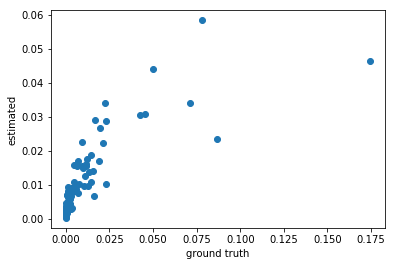

In [41]:
importance_true = importance(data_source, params)
importance_true = importance_true / np.sum(importance_true)

importance_est = lsdr.predict(data_source)
importance_est = importance_est/ np.sum(importance_est)

plt.plot(importance_true , importance_est , 'o')
plt.xlabel("ground truth")
plt.ylabel("estimated")
plt.show()

Using the estimated importance, we can perform the learning. 
For comparison, results for 
* learning without taking into account of importance, and
* learning with the true importance given
are also shown.

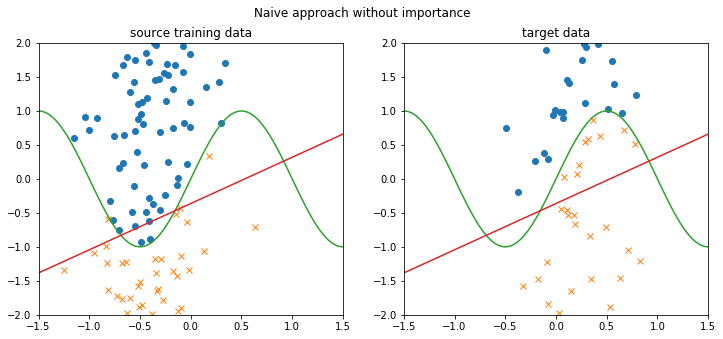

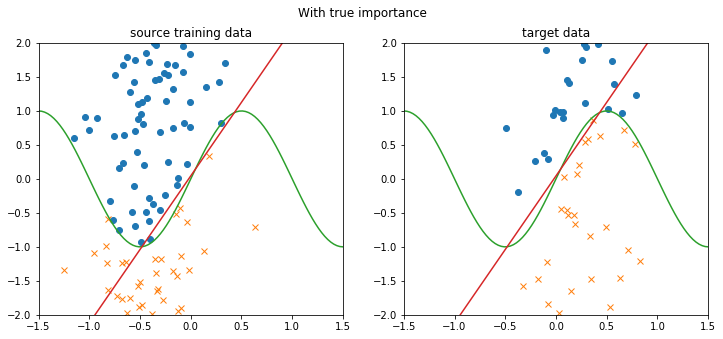

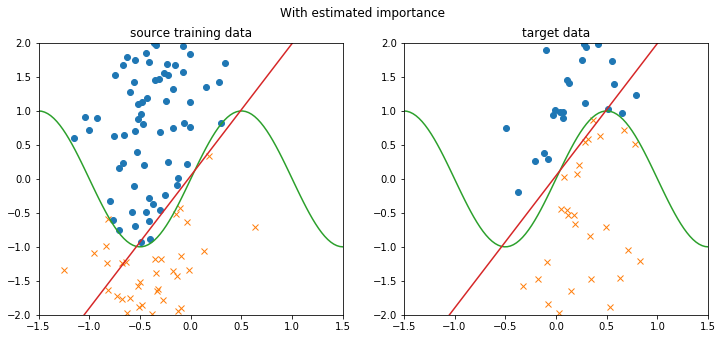

In [42]:
clf_weight_est = LogisticRegression_covshift(penalty='l2', C = 1e50)
clf_weight_est.fit_covshift(data_source, label_source, lambda x, p : lsdr.predict(x), params)

plot_fig_result(data_source, data_target, label_source, label_target, xlims, ylims, clf_naive, "Naive approach without importance")
plot_fig_result(data_source, data_target, label_source, label_target, xlims, ylims, clf_weight_known, "With true importance")
plot_fig_result(data_source, data_target, label_source, label_target, xlims, ylims, clf_weight_est, "With estimated importance")

## 5. Reference

* [1] 杉山将(2013)「イラストで学ぶ機械学習」講談社
* [2] Pan, Yang (2010) "A Survey on Transfer Learning" IEEE Transactions on Knowledge and Data Engineering. retrieved from https://www.cse.ust.hk/~qyang/Docs/2009/tkde_transfer_learning.pdf
* [3] Sebastian Ruder (2017) "Transfer Learning - Machine Learning's Next Frontier" http://ruder.io/transfer-learning/
* [4] Hidetoshi Shimodaira (2000) "Improving predictive inference under covariate shift by weighting the log-likelihood function" Journal of Statistical Planning and Inference. retrieved from http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.370.4921&rep=rep1&type=pdf
* [5] Takafumi Kanamori, Shohei Hido, Masashi Sugiyama (2009) "A Least-squares Approach to Direct Importance Estimation" Journal of Machine Learning Research 10, 1391-1445. retrieved from http://www.jmlr.org/papers/volume10/kanamori09a/kanamori09a.pdf
* [6] Yuta Tsuboi, Hisashi Kashima, Shohei Hido, Steffen Bickel, Masashi Sugiyama. (2009) "Direct Density Ratio Estimation for Large-scale Covariate Shift Adaptation" Journal of Information Processing, Vol. 17, pp.138-155. retrieve from https://pdfs.semanticscholar.org/6b0b/12fbd2455c37131ac1cedc5137a9fd7c3e53.pdf